<a href="https://colab.research.google.com/github/logan-abo/Agent-Brawl/blob/main/Vision_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import torch
import torch.nn as nn

import torchvision.models as models
from torchvision.models import mobilenet_v2
import torchvision.transforms as T

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split

from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import random

import json

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageDraw

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The Model

In [ ]:
class CoordRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = mobilenet_v2(pretrained=True)

        self.features = backbone.features

        self.regressor = nn.Sequential(
            nn.Flatten(),

            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(128, 2),
            nn.Sigmoid()  # for normalized output in [0, 1]
        )

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1)  # [B, C, 1, 1]
        return self.regressor(x)

In [ ]:
criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

## Custom Dataset

In [ ]:
class HorizontalFlipWithLabel:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, label):
        if torch.rand(1).item() < self.p:
            img = T.functional.hflip(img)
            label = torch.tensor([1.0 - label[0], label[1]], dtype=torch.float32)
        return img, label

In [ ]:
class RandomAffineWithLabel:
    def __init__(self, max_translate=(0.05, 0.05), p=1.0):
        """
        max_translate: (x_frac, y_frac) in normalized image units
        p: probability of applying the transform
        """
        self.max_dx = max_translate[0]
        self.max_dy = max_translate[1]
        self.p = p

    def __call__(self, img, label):
        if random.random() > self.p:
            return img, label  # no-op

        w, h = img.size

        # Max pixel shifts
        max_dx_px = int(self.max_dx * w)
        max_dy_px = int(self.max_dy * h)

        # Random pixel shifts
        tx = random.randint(-max_dx_px, max_dx_px)
        ty = random.randint(-max_dy_px, max_dy_px)

        # Apply affine (rotation=0, scale=1, shear=0, translation=(tx, ty))
        img = F.affine(img, angle=0, translate=(tx, ty), scale=1.0, shear=0)

        # Adjust label (normalized)
        new_x = label[0] + tx / w
        new_y = label[1] + ty / h

        # Clamp to [0, 1]
        new_x = max(0.0, min(1.0, new_x))
        new_y = max(0.0, min(1.0, new_y))

        new_label = torch.tensor([new_x, new_y], dtype=torch.float32)
        return img, new_label

In [ ]:
class ConditionalMaskCenter:
    def __init__(self, radius_px=30, p=0.5, min_center_dist=0.2):
        """
        radius_px: how big the blacked-out mask should be
        p: probability of applying the mask (if condition met)
        min_center_dist: only apply if label is at least this far from center (in normalized units)
        """
        self.radius = radius_px
        self.p = p
        self.min_dist = min_center_dist

    def __call__(self, img, label):
        # Check center distance
        dx = label[0] - 0.5
        dy = label[1] - 0.5
        dist = torch.sqrt(dx**2 + dy**2)

        if dist >= self.min_dist and random.random() < self.p:
            # Mask the center of the image
            draw = ImageDraw.Draw(img)
            w, h = img.size
            cx, cy = w // 2, h // 2
            draw.rectangle([cx - self.radius, cy - self.radius,
                            cx + self.radius, cy + self.radius],
                           fill="black")
        return img, label

In [ ]:
class BrawlDataset(Dataset):
    def __init__(self, root_dir, labels_path, transform=None, extra_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.extra_transform = extra_transform

        with open(labels_path, "r") as f:
            self.labels = json.load(f)

        self.filenames = list(self.labels.keys())

    def __len__(self):
        return len(self.filenames)

    def find_image_path(self, filename):
        for subdir, _, files in os.walk(self.root_dir):
            if filename in files:
                return os.path.join(subdir, filename)
        return None

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        path = self.find_image_path(filename)

        if path is None:
            raise FileNotFoundError(f"Image not found: {filename}")

        img = Image.open(path).convert("RGB")
        img = img.rotate(90, expand=True)

        label = torch.tensor(self.labels[filename], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        if self.extra_transform:
            img, label = self.extra_transform(img, label)

        return img, label

## Transforms

In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.Resize((224, 224)),           # Required input size
    T.ToTensor(),                   # Converts [0-255] to [0.0–1.0]
    T.Normalize(mean, std)
])

unnorm = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean, std)
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

extra_transform = T.Compose([
    ConditionalMaskCenter(radius_px=60, p=0.5, min_center_dist=0.2679),
    HorizontalFlipWithLabel(p=0.5),
    RandomAffineWithLabel(max_translate=(0.05, 0.05), p=1.0)
])

## Data Loaders

In [ ]:
# Step 1: Load full label list
with open("/content/drive/MyDrive/ML/labels.json", "r") as f:
    all_labels = json.load(f)
all_filenames = list(all_labels.keys())

# Step 2: Split filenames
train_files, testval_files = train_test_split(all_filenames, test_size=0.30, random_state=42)
val_files, test_files = train_test_split(testval_files, test_size=0.50, random_state=42)

# Step 3: Define custom constructor to limit filenames
class BrawlDatasetFiltered(BrawlDataset):
    def __init__(self, root_dir, labels_path, filenames, transform=None, extra_transform=None):
        super().__init__(root_dir, labels_path, transform, extra_transform)
        self.filenames = filenames  # limit to subset

# Step 4: Create separate dataset instances
train_dataset = BrawlDatasetFiltered(
    root_dir="/content/drive/MyDrive/ML",
    labels_path="/content/drive/MyDrive/ML/labels.json",
    filenames=train_files,
    transform=train_transform,                     # normal image-only transforms
    extra_transform=extra_transform                # label-aware transforms
)

val_dataset = BrawlDatasetFiltered(
    root_dir="/content/drive/MyDrive/ML",
    labels_path="/content/drive/MyDrive/ML/labels.json",
    filenames=val_files,
    transform=val_transform
)

test_dataset = BrawlDatasetFiltered(
    root_dir="/content/drive/MyDrive/ML",
    labels_path="/content/drive/MyDrive/ML/labels.json",
    filenames=test_files,
    transform=val_transform
)

# Step 5: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

## plot_losses()

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## visualize_prediction()

In [ ]:
def visualize_predictions(model, dataset, num_samples=10):
    model.eval()
    device = next(model.parameters()).device

    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]

    plt.figure(figsize=(15, 8))

    for i, (img_tensor, true_label) in enumerate(samples):
        img_tensor = img_tensor.to(device)
        true_label = true_label.to(device)

        with torch.no_grad():
            pred = model(img_tensor.unsqueeze(0)).squeeze(0)

        # Undo normalization for display
        img_display = unnorm(img_tensor.cpu()).clamp(0, 1)
        img_display = T.ToPILImage()(img_display)

        draw = ImageDraw.Draw(img_display)
        w, h = img_display.size

        # Convert normalized to pixel coordinates
        pred_px = (pred * torch.tensor([w, h], device=pred.device)).cpu().numpy().astype(int)
        true_px = (true_label * torch.tensor([w, h], device=true_label.device)).cpu().numpy().astype(int)

        # Draw predicted green dot
        r = 4
        draw.ellipse((pred_px[0] - r, pred_px[1] - r, pred_px[0] + r, pred_px[1] + r), fill="green")

        # Draw true red dot
        draw.ellipse((true_px[0] - r, true_px[1] - r, true_px[0] + r, true_px[1] + r), fill="red")

        # Pixel error
        pixel_error = np.linalg.norm(pred_px - true_px)

        plt.subplot(2, 5, i+1)
        plt.imshow(img_display)
        plt.title(f"Error: {pixel_error:.1f}px")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## TRAIN

In [ ]:
train_dataset.transform = train_transform
train_dataset.extra_transform = HorizontalFlipWithLabel(p=0.5)

val_dataset.transform = val_transform
val_dataset.extra_transform = None


# === Setup ===


model = CoordRegressor().to("cuda" if torch.cuda.is_available() else "cpu")

for param in model.features.parameters():
        param.requires_grad = True

optimizer = torch.optim.Adam([
    {'params': model.features[0:6].parameters(),   'lr': 1e-4},
    {'params': model.features[6:12].parameters(),  'lr': 3e-4},
    {'params': model.features[12:].parameters(),   'lr': 5e-4},
    {'params': model.regressor.parameters(),       'lr': 1e-3}
], weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


criterion = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Train ===
train_losses, val_losses, val_distances = [], [], []


early_stop_patience = 8
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

for epoch in range( 35 ):
    model.train()
    total_train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()

        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        print(f"Epoch {epoch+1:02d} | Grad Norm: {total_norm:.4f}")

        optimizer.step()
        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    total_val_distance = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            total_val_loss += loss.item()

            distances = torch.norm(preds - labels, dim=1)  # Euclidean
            total_val_distance += distances.sum().item()

    val_loss = total_val_loss / len(val_loader)
    avg_distance = total_val_distance / len(val_dataset)

    val_losses.append(val_loss)
    val_distances.append(avg_distance)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dist: {avg_distance:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
        print("New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= early_stop_patience:
        print("Early stopping triggered.")
        early_stop = True
        break  # exits the loop

    for i, group in enumerate(optimizer.param_groups):
        print(f"LR[{i}]: {group['lr']:.2e}")


    # # === Unfreeze MobileNetV2 top layers after warmup ===
    # if epoch == 10:
    #     # Unfreeze last N layers
    #     for param in model.features[-3:].parameters():
    #         param.requires_grad = True
    #     print("Unfroze top MobileNetV2 layers for fine-tuning.")

    #     lr_factor = 0.1
    #     for param_group in optimizer.param_groups:
    #         old_lr = param_group['lr']
    #         param_group['lr'] = old_lr * lr_factor
    #         print(f"Learning rate reduced from {old_lr:.2e} to {param_group['lr']:.2e}")

    # if epoch == 20:
    #     # Unfreeze last N layers
    #     for param in model.features[-5:].parameters():
    #         param.requires_grad = True
    #     print("Unfroze Higher MobileNetV2 layers for fine-tuning.")

    #     lr_factor = 0.1
    #     for param_group in optimizer.param_groups:
    #         old_lr = param_group['lr']
    #         param_group['lr'] = old_lr * lr_factor
    #         print(f"Learning rate reduced from {old_lr:.2e} to {param_group['lr']:.2e}")

torch.save(model.state_dict(), "final_model.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 74.3MB/s]


Epoch 01 | Grad Norm: 1.5394
Epoch 01 | Grad Norm: 1.1096
Epoch 01 | Grad Norm: 0.9303
Epoch 01 | Grad Norm: 0.7703
Epoch 01 | Grad Norm: 0.7228
Epoch 01 | Grad Norm: 0.5869
Epoch 01 | Grad Norm: 0.5249
Epoch 01 | Grad Norm: 0.7392
Epoch 01 | Grad Norm: 0.4400
Epoch 01 | Grad Norm: 0.4606
Epoch 01 | Grad Norm: 0.4106
Epoch 01 | Grad Norm: 0.8319
Epoch 01 | Train Loss: 0.0387 | Val Loss: 0.0602 | Val Dist: 0.3091
New best model saved.
LR[0]: 1.00e-04
LR[1]: 3.00e-04
LR[2]: 5.00e-04
LR[3]: 1.00e-03
Epoch 02 | Grad Norm: 0.3523
Epoch 02 | Grad Norm: 0.3900
Epoch 02 | Grad Norm: 0.3589
Epoch 02 | Grad Norm: 0.3693
Epoch 02 | Grad Norm: 0.3071
Epoch 02 | Grad Norm: 0.3569
Epoch 02 | Grad Norm: 0.2943
Epoch 02 | Grad Norm: 0.2451
Epoch 02 | Grad Norm: 0.2682
Epoch 02 | Grad Norm: 0.2485
Epoch 02 | Grad Norm: 0.3016
Epoch 02 | Grad Norm: 0.5159
Epoch 02 | Train Loss: 0.0175 | Val Loss: 0.0093 | Val Dist: 0.1096
New best model saved.
LR[0]: 1.00e-04
LR[1]: 3.00e-04
LR[2]: 5.00e-04
LR[3]: 1.00e

## DIAGNOSTICS

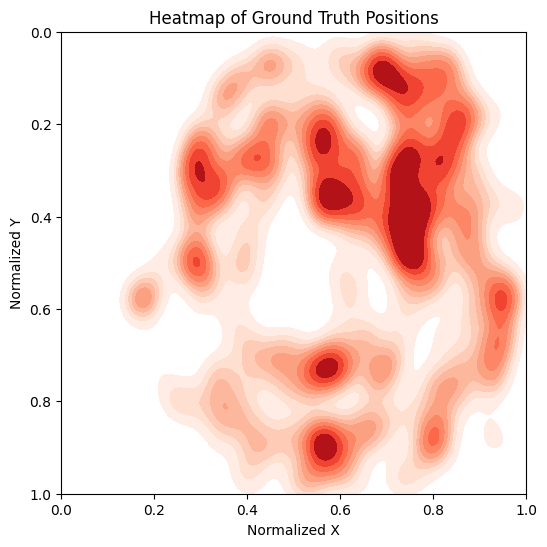

In [ ]:
# Load all labels
with open("/content/drive/MyDrive/ML/labels.json", "r") as f:
    labels = json.load(f)

coords = np.array(list(labels.values()))

plt.figure(figsize=(6, 6))
sns.kdeplot(x=coords[:, 0], y=coords[:, 1], fill=True, cmap="Reds", bw_adjust=0.4, clip=((0,1),(0,1)))
plt.title("Heatmap of Ground Truth Positions")
plt.xlabel("Normalized X")
plt.ylabel("Normalized Y")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().invert_yaxis()  # Optional: if your game Y=0 is at top
plt.show()

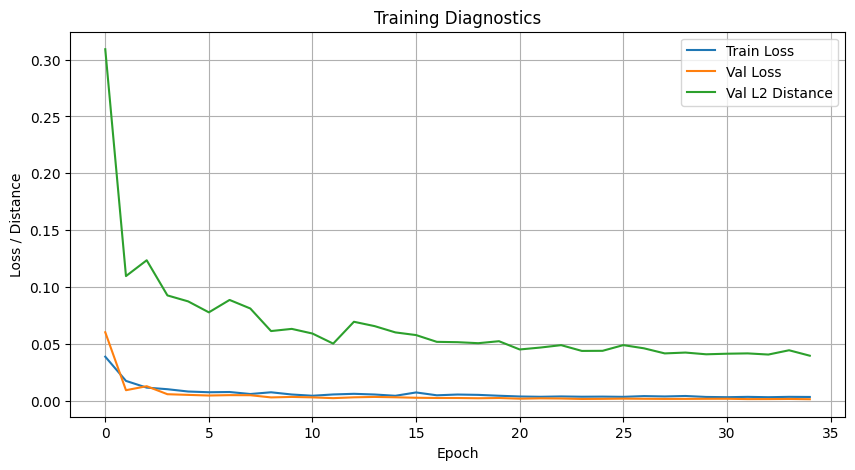

In [ ]:
# === Plot diagnostics ===
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_distances, label="Val L2 Distance")
plt.xlabel("Epoch")
plt.ylabel("Loss / Distance")
plt.title("Training Diagnostics")
plt.legend()
plt.grid(True)
plt.show()

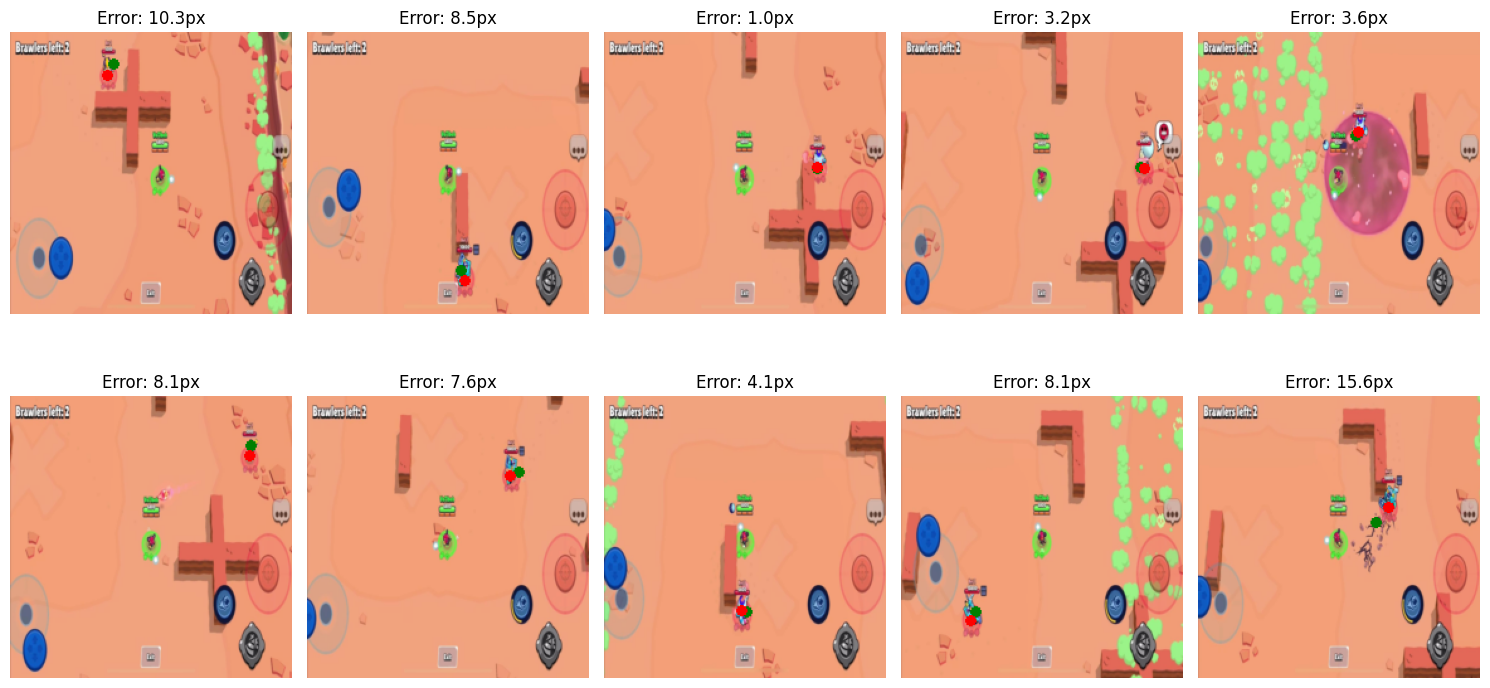

In [ ]:
visualize_predictions(model, test_dataset, num_samples=10)

## EXTRA

In [ ]:
!ls -lh /content/

total 23M
-rw-r--r-- 1 root root  12M May 13 17:02 best_model.pth
drwx------ 6 root root 4.0K May 13 16:48 drive
-rw-r--r-- 1 root root  12M May 13 17:02 final_model.pth
drwxr-xr-x 1 root root 4.0K May  9 13:41 sample_data


In [ ]:
!cp /content/final_model.pth /content/drive/MyDrive/

In [ ]:
def visualize_bounding_box_predictions(model, dataset, indices):
    model.eval()
    device = next(model.parameters()).device

    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices) * 4, 4))
    if len(indices) == 1:
        axes = [axes]

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, _ = dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)
            pred = model(img_tensor).squeeze(0).cpu().numpy()

            # Unnormalize and convert to real image
            img = dataset[idx][0].clone()
            if hasattr(dataset, 'unnorm'):
                img = dataset.unnorm(img)
            img = img.permute(1, 2, 0).numpy()
            img = np.clip(img * 255, 0, 255).astype(np.uint8)
            pil_img = Image.fromarray(img)
            w, h = pil_img.size
            draw = ImageDraw.Draw(pil_img)

            # Draw bounding box for prediction
            pred_x = int(pred[0] * w)
            pred_y = int(pred[1] * h)
            r = 6
            draw.rectangle([pred_x - r, pred_y - r, pred_x + r, pred_y + r], outline="white", width=4)
            draw.rectangle([pred_x - r, pred_y - r, pred_x + r, pred_y + r], outline="green", width=3)

            axes[i].imshow(pil_img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {idx}")

    plt.tight_layout()
    plt.show()

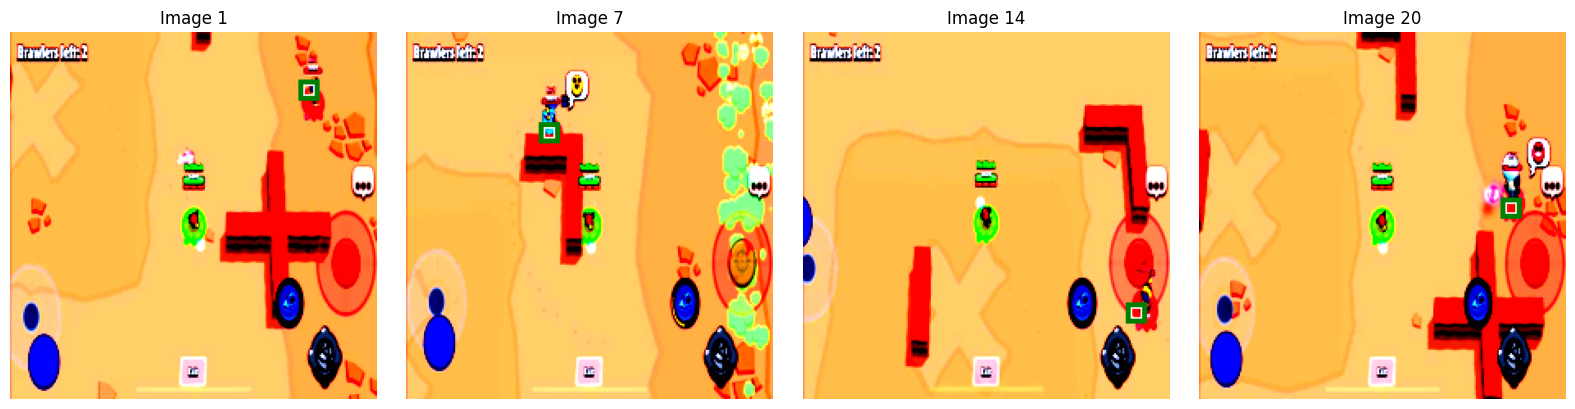

In [ ]:
visualize_bounding_box_predictions(model, test_dataset, indices=[1, 7, 14, 20])


In [ ]:
def evaluate_prediction_accuracy(model, dataset, radius=0.05):
    model.eval()
    device = next(model.parameters()).device

    all_errors = []

    with torch.no_grad():
        for img, label in dataset:
            img = img.unsqueeze(0).to(device)
            pred = model(img).squeeze(0).cpu().numpy()
            true = label.numpy()
            error = np.linalg.norm(pred - true)
            all_errors.append(error)

    all_errors = np.array(all_errors)
    within_radius = all_errors <= radius
    percent_within = 100 * np.mean(within_radius)

    print(f"✅ {percent_within:.2f}% of predictions fall within a radius of {radius} (normalized units)")
    print(f"Average error: {np.mean(all_errors):.4f}")

    # Optional histogram
    plt.hist(all_errors, bins=30, edgecolor='black')
    plt.axvline(radius, color='red', linestyle='--', label=f'Threshold ({radius})')
    plt.title("Prediction Error Distribution")
    plt.xlabel("L2 Distance from True Label")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

✅ 78.21% of predictions fall within a radius of 0.05 (normalized units)
Average error: 0.0355


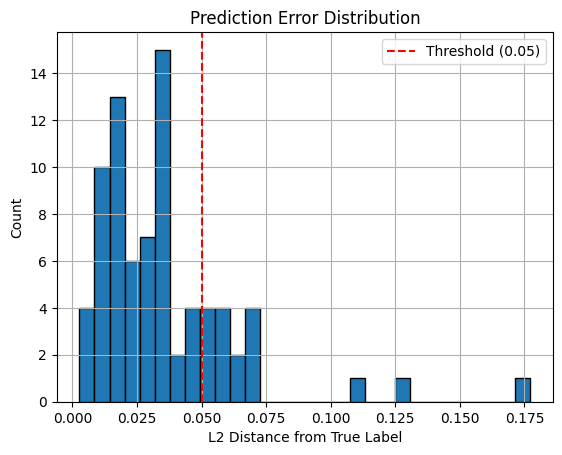

In [ ]:
evaluate_prediction_accuracy(model, test_dataset, radius=0.05)
